In [1]:
import sys
dirname = '/Users/m.daffarobani/Documents/personal_research/smt'
if dirname not in sys.path:
    sys.path.append(dirname)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from smt.utils.design_space import (
    DesignSpace,
    FloatVariable,
    CategoricalVariable,
)
from smt.surrogate_models import KRG, MixIntKernelType
from sklearn.metrics import mean_squared_error

from smt.explainability_tools import PartialDependenceDisplay, PDFeatureImportanceDisplay
from smt.explainability_tools import partial_dependence, pd_feature_importance

import matplotlib.pyplot as plt

In [2]:
def read_vtf_data():
    categorical_columns = ['Carbon_fibre', 'Glass_fibre']
    df = pd.read_csv("../tutorial/VTF_properties.csv")
    dropped_columns = [
        'SmAvg',
        'G',
        'GiicmAvg',
        'Ultimate_strain',
        'Pseudo_ductile_strain',
        'Ultimate_strength',
        'Yield_strength',
    ]
    df = df.drop(dropped_columns, axis=1)
    for column in categorical_columns:
        df[column] = pd.Categorical(df[column])
    return df

def take_and_map_top_categories(df, n=None):
    df = df.copy()
    numeric_columns = df._get_numeric_data().columns
    categorical_columns = [column for column in df if column not in numeric_columns]
    columns_index = {column: i for i, column in enumerate(df.columns)}

    categories_map = {}
    categories_inverse_map = {}

    for column in categorical_columns:
        categories_map[columns_index[column]] = {}
        categories_inverse_map[columns_index[column]] = {}
        categories = df[column].value_counts().index.to_list()

        if n is not None:
            categories = categories[:n]
            df[column] = df[column].apply(lambda x: x if x in categories else "others")
            if (df[column]=="others").sum() > 0:
                categories.append("others")
                
        for i in range(len(categories)):
            categories_map[columns_index[column]][categories[i]] = i
            categories_inverse_map[columns_index[column]][i] = categories[i]
        df[column] = df[column].apply(lambda x: categories_map[columns_index[column]][x])            
    return df, categories_map, categories_inverse_map

In [3]:
df = read_vtf_data()
data = df.sample(n=1000, random_state=10)
data, categories_map, categories_inverse_map = take_and_map_top_categories(data, n=7)
Xd = data.drop(["Initial_stiffness"], axis=1)
yd = data["Initial_stiffness"]

X_train, X_test, y_train, y_test = train_test_split(Xd, yd, test_size = 0.25, random_state = 42)
X_tr = np.asarray(X_train)
y_tr = np.asarray(y_train).astype(float)
X_te = np.asarray(X_test)
y_te = np.asarray(y_test).astype(float)

# to define the variables
design_space = DesignSpace (
    [
        CategoricalVariable (list(categories_map[0].keys())),
        CategoricalVariable (list(categories_map[1].keys())),
        FloatVariable (501.5425023,11999.96175),
        FloatVariable (2.849e-05,1.0),
    ]
    )

sm=KRG(design_space = design_space, print_global=False, categorical_kernel=MixIntKernelType.GOWER)
sm.set_training_values(X_tr, y_tr)
sm.train()
y_pred = sm.predict_values(X_te)
rmse = mean_squared_error(y_te, y_pred, squared=False)
rrmse = rmse / y_te.mean()
print(f"RMSE: {rmse:.4f}")
print(f"rRMSE: {rrmse:.4f}")
# note:
# try with a simpler mixed variables example
# e.g., analytical problems with low dimension

RMSE: 39221.2890
rRMSE: 0.1880


In [4]:
categories_map

{0: {'K13D': 0,
  'XN-90': 1,
  'C124': 2,
  'T1000GB': 3,
  'P120J': 4,
  'HTA5131': 5,
  'C320': 6,
  'others': 7},
 1: {'C100': 0,
  'C124': 1,
  'C320': 2,
  'T300': 3,
  'T1000GB': 4,
  'T800H': 5,
  'P120J': 6,
  'others': 7}}

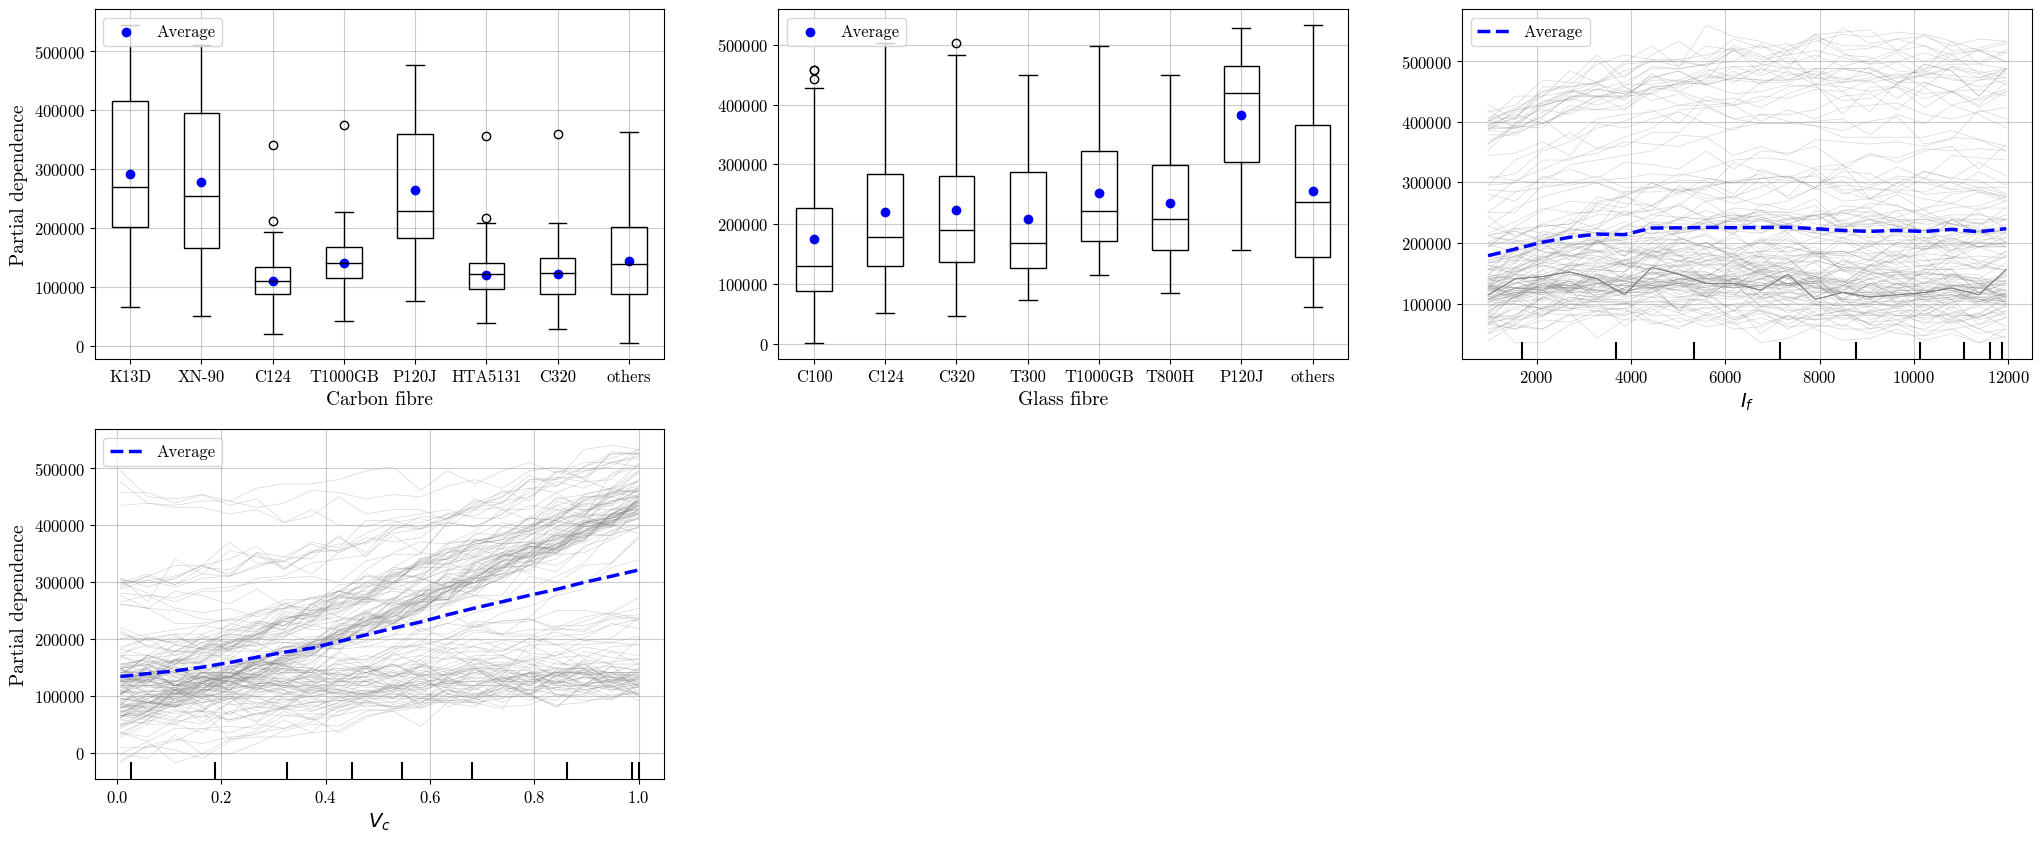

In [4]:
model = sm
X = X_tr
feature_names = [
    r'Carbon fibre', 
    r'Glass fibre', 
    r'$I_{f}$', 
    r'$V_{c}$', 
    ]

features = [0, 1, 2, 3]
categorical_features = [0, 1]

pdd = PartialDependenceDisplay.from_surrogate_model(
    model, 
    X, 
    features, 
    categorical_features=categorical_features, 
    feature_names=feature_names,
    grid_resolution=20,
    kind='both',
    ratio_samples = 0.2,
    inverse_categories_map=categories_inverse_map,
    centered=False,
    figsize=[25, 10]
    )

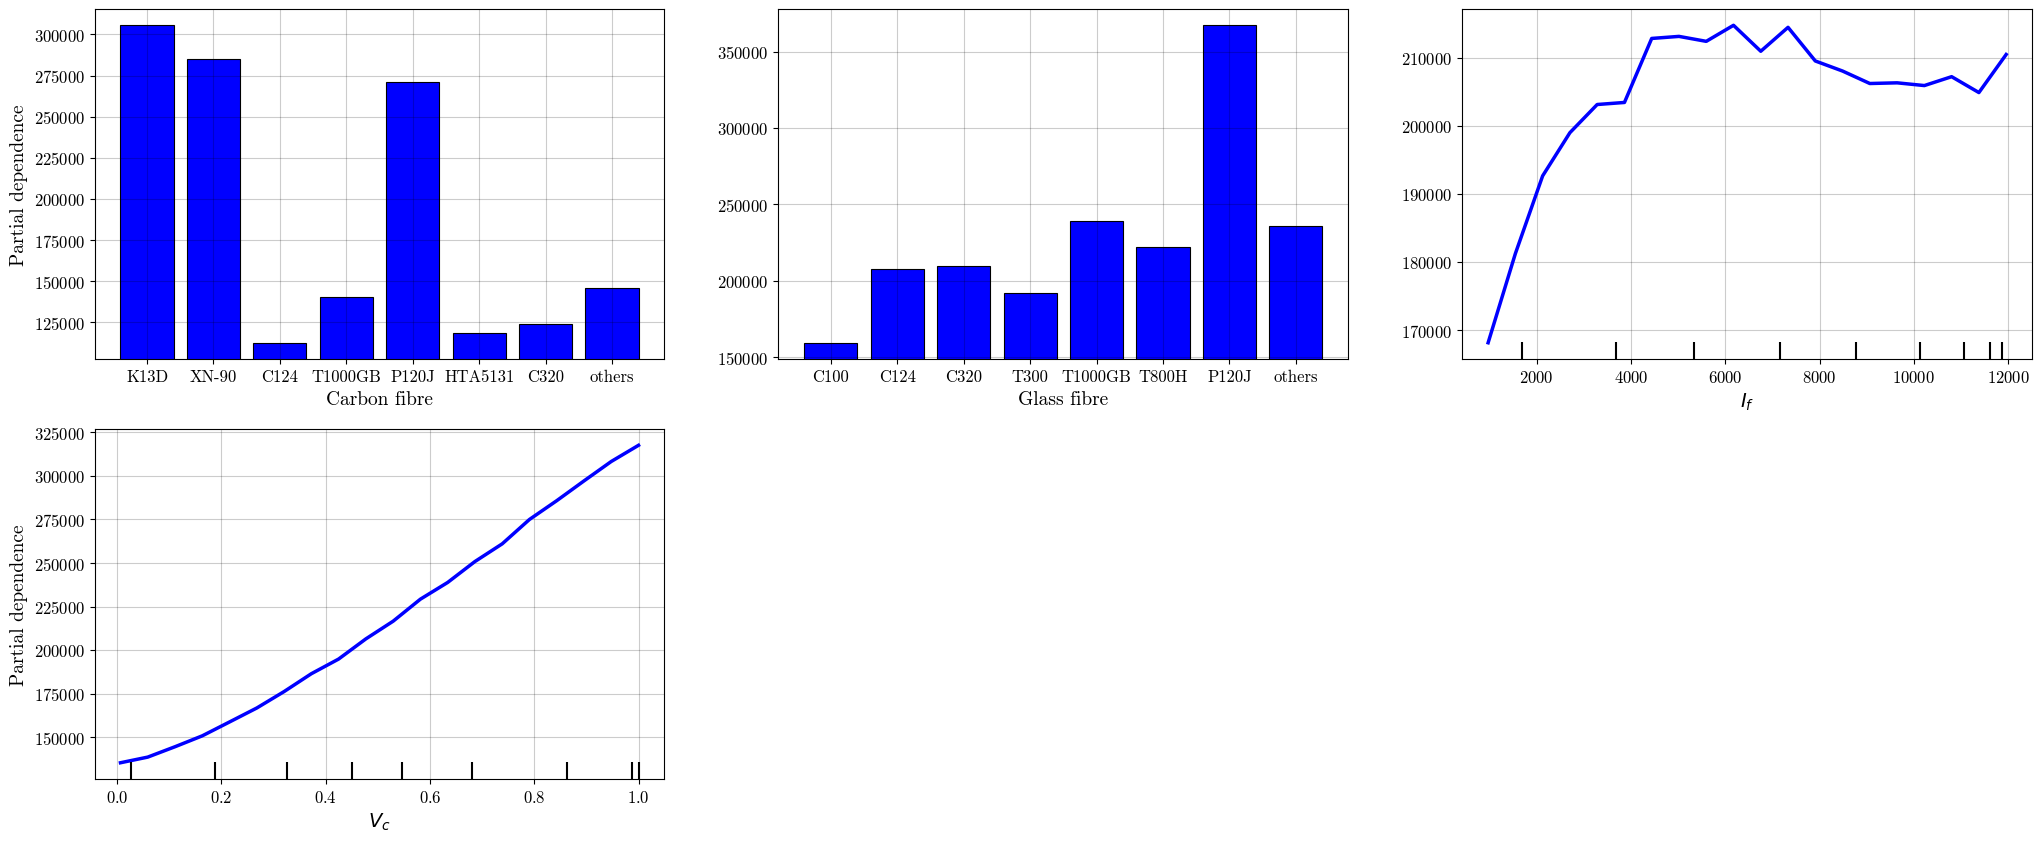

In [8]:
model = sm
X = X_tr
feature_names = [
    r'Carbon fibre', 
    r'Glass fibre', 
    r'$I_{f}$', 
    r'$V_{c}$', 
    ]

features = [0, 1, 2, 3]
categorical_features = [0, 1]

pdd = PartialDependenceDisplay.from_surrogate_model(
    model, 
    X, 
    features, 
    categorical_features=categorical_features, 
    feature_names=feature_names,
    grid_resolution=20,
    kind='average',
    ratio_samples = 0.2,
    inverse_categories_map=categories_inverse_map,
    centered=False,
    figsize=[25, 10]
    )

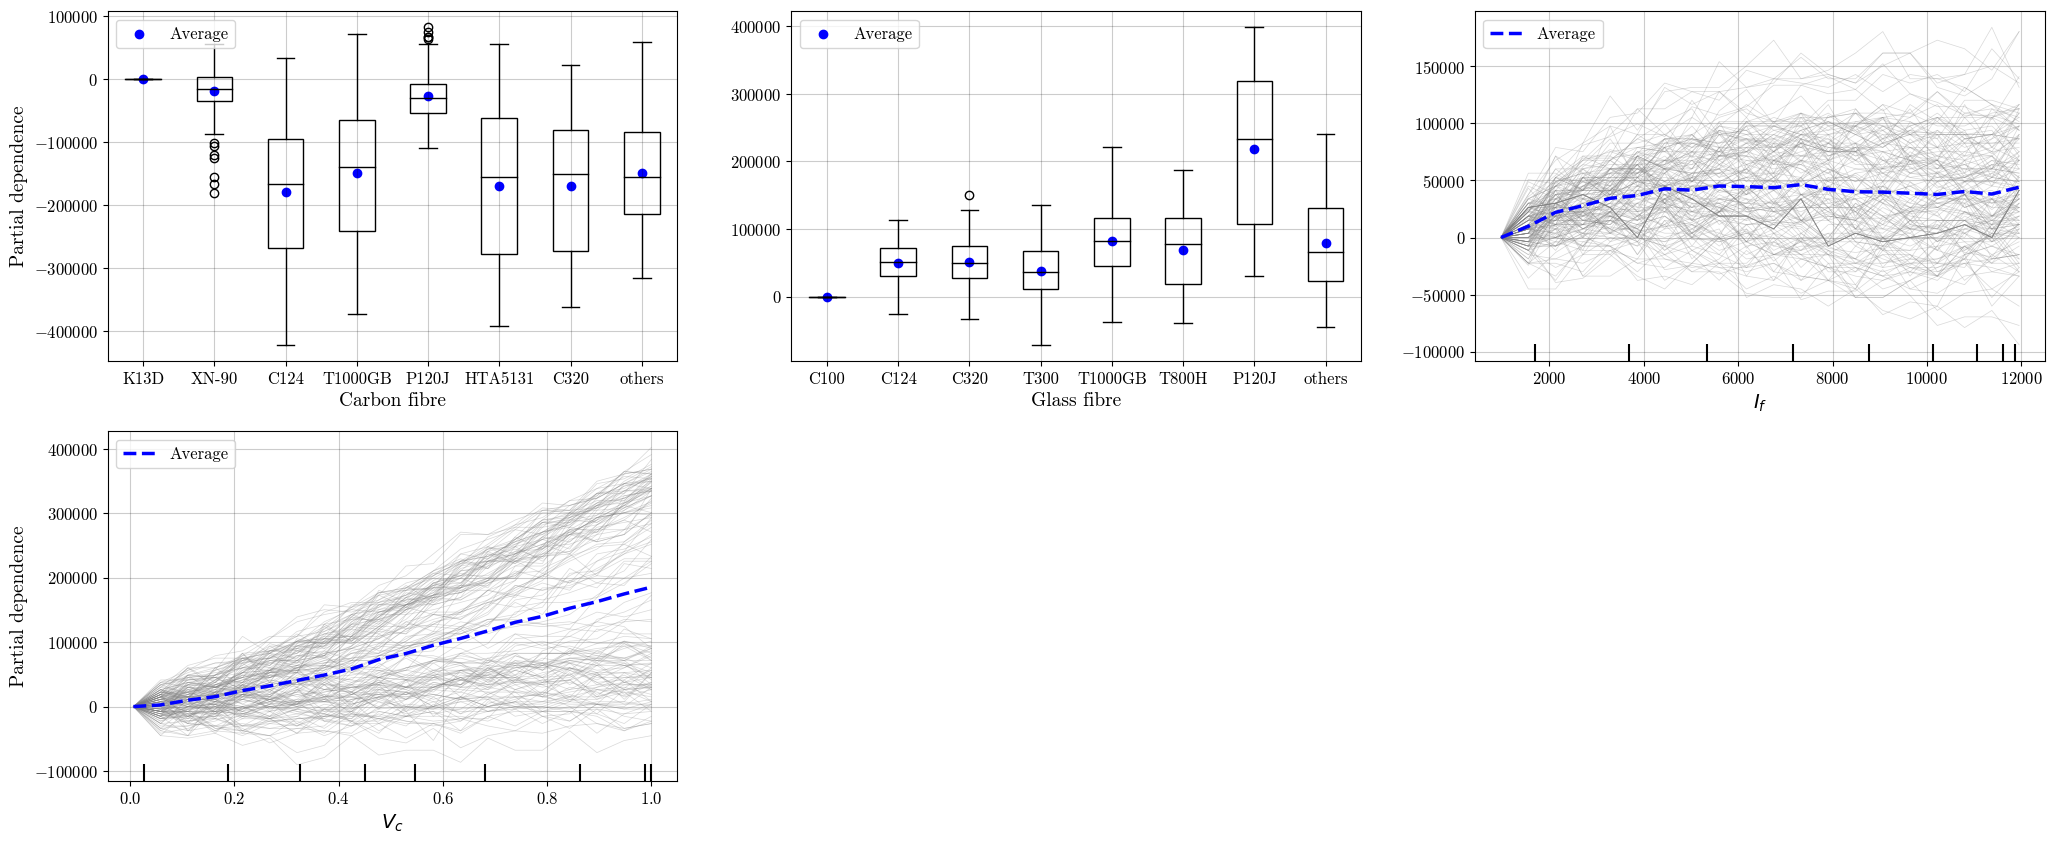

In [5]:
model = sm
X = X_tr
feature_names = [
    r'Carbon fibre', 
    r'Glass fibre', 
    r'$I_{f}$', 
    r'$V_{c}$', 
    ]

features = [0, 1, 2, 3]
categorical_features = [0, 1]

pdd = PartialDependenceDisplay.from_surrogate_model(
    model, 
    X, 
    features, 
    categorical_features=categorical_features, 
    feature_names=feature_names,
    grid_resolution=20,
    kind='both',
    ratio_samples = 0.2,
    inverse_categories_map=categories_inverse_map,
    centered=True,
    figsize=[25, 10]
    )

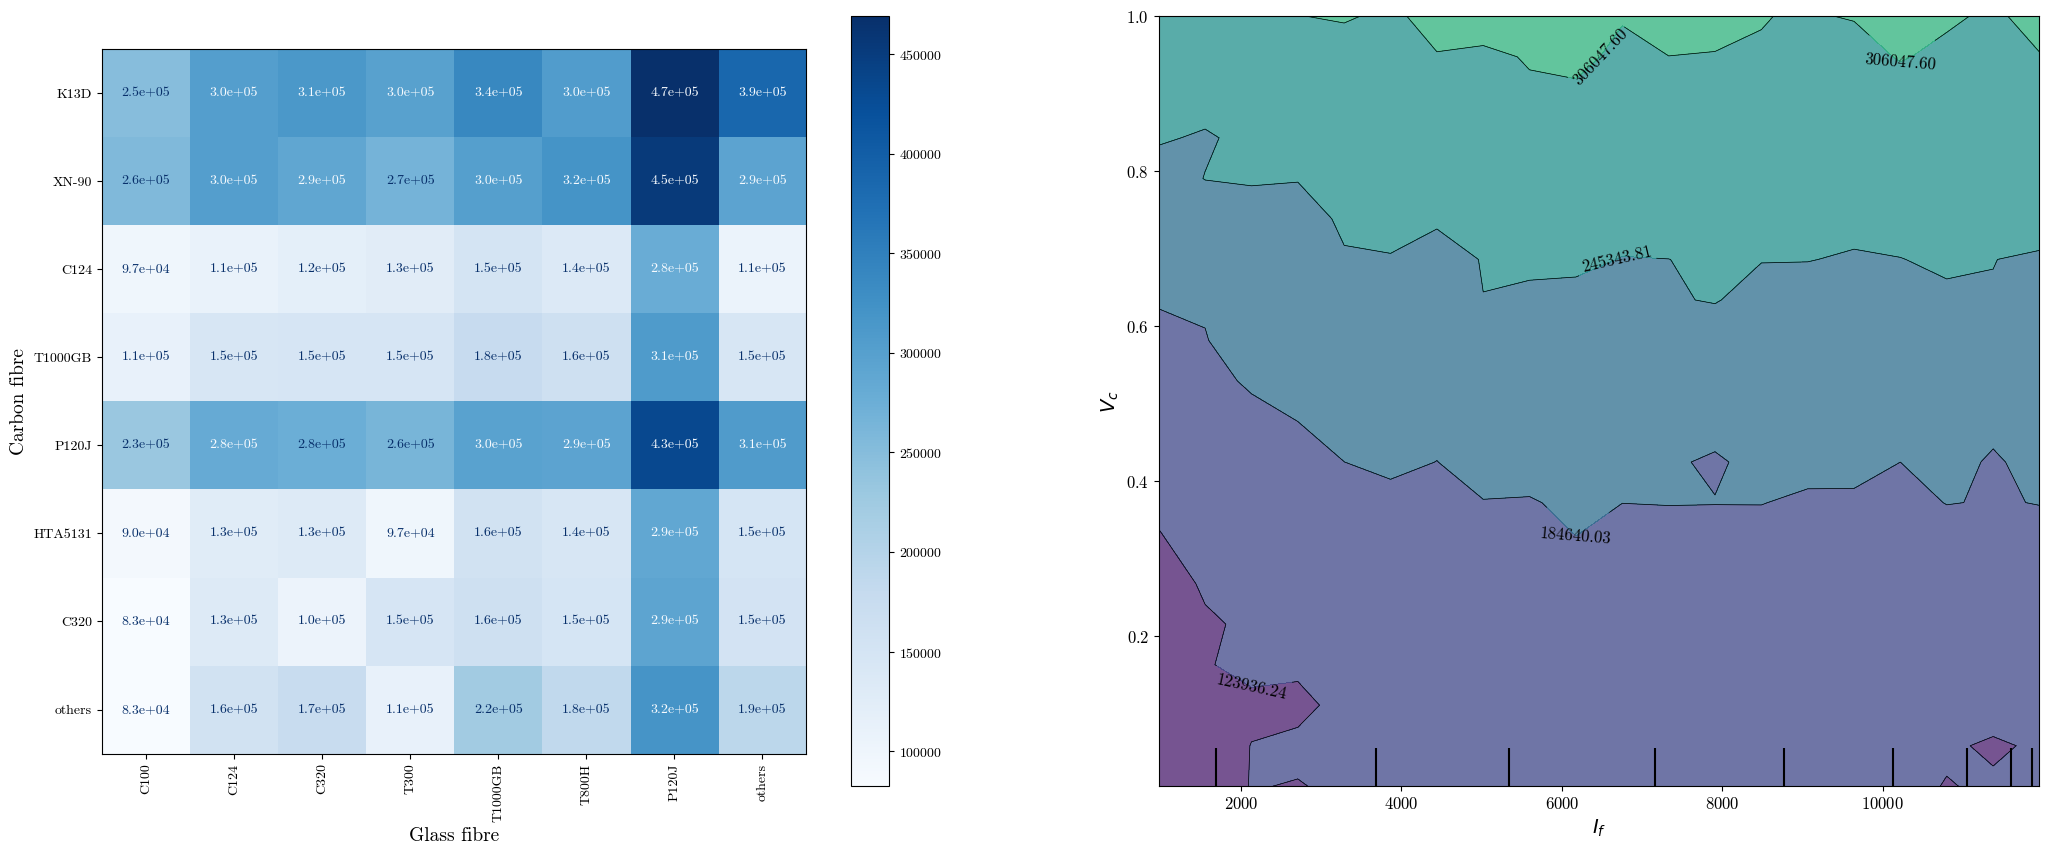

In [6]:
model = sm
X = X_tr
feature_names = [
    r'Carbon fibre', 
    r'Glass fibre', 
    r'$I_{f}$', 
    r'$V_{c}$', 
    ]

features = [(0, 1), (2, 3)]
categorical_features = [0, 1]

pdd = PartialDependenceDisplay.from_surrogate_model(
    model, 
    X, 
    features, 
    categorical_features=categorical_features, 
    feature_names=feature_names,
    grid_resolution=20,
    kind='both',
    ratio_samples = 0.2,
    inverse_categories_map=categories_inverse_map,
    centered=False,
    figsize=[25, 10]
    )

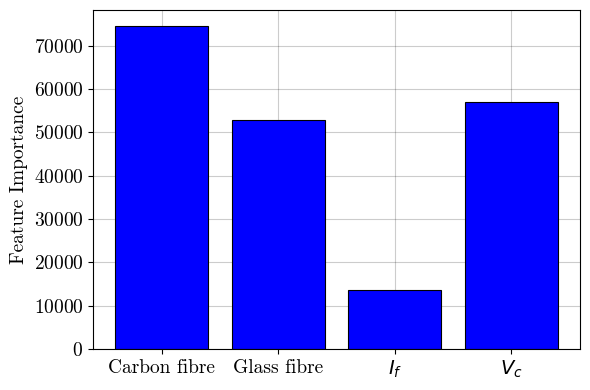

In [7]:
model = sm
X = X_tr
feature_names = [
    r'Carbon fibre', 
    r'Glass fibre', 
    r'$I_{f}$', 
    r'$V_{c}$', 
    ]

feature_importance = PDFeatureImportanceDisplay.from_surrogate_model(
    model, 
    X_tr, 
    feature_names=feature_names, 
    sorted=False,
    ratio_samples=0.2,
    grid_resolution=20,
    figsize=[6, 4]
)